# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [24]:
#import all modules and libraries

import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [11]:
#load the data, making datetime column the index, convert to datetime type

data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

#to check if data is sorted
print(data.index.is_monotonic)

print(data.head())
data.info()

True
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Our dataset look pretty good. only thing we need to do is to resample our data by hour. 

In [12]:
#resample by hour

data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


We can start analyzing our data. 

## Analysis

Let's analyze the trends and seasonality in different time frames. Residual graph does not tell us much, so we will use a small slice of dates instead.

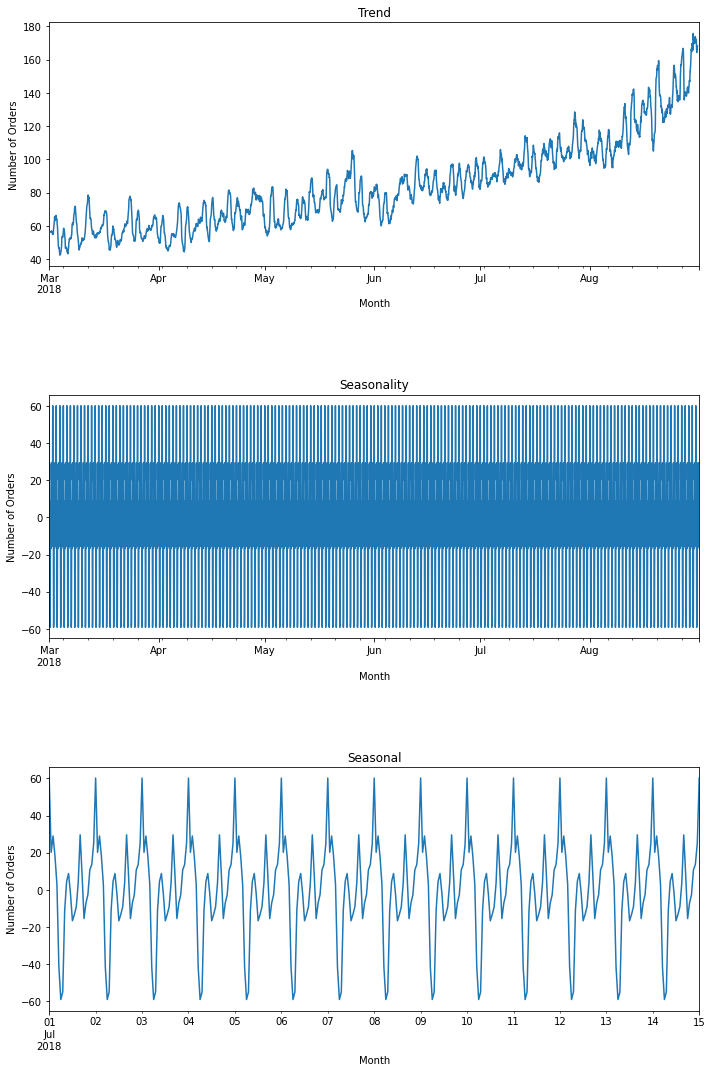

In [13]:
#decompose our data
decomposed = seasonal_decompose(data)

plt.figure(figsize = (10,15))

#trend graph
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#seasonality graph
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#small slice

plt.subplot(313)
decomposed.seasonal['2018-07-01 00:00:00': '2018-07-15 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Number of Orders')


plt.tight_layout(h_pad=7)
plt.show()

Our trend graph showed that the growth is relatively linear between March to August, with the number of orders ranging from 40 - 180.

As we can see, the first seasonality graph is not very clear, after we took a small slice, we got a more clear seasonality graph. We see that the amplitude of the peaks are between -60 and 60, the pattern is repeating daily. Therefore it suggest that we can determine the customer trends by the hour, because that the peak hours occurs about the same time everyday. 

## Training

Now we train a model to predict the number of customers in the next hour, we will need to add more features. 

 We will use the shift method. 

We will make features by month, day, hour, and dayofweek. 

In [14]:
#make features

def make_features(data, max_lag, roll_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #data['previous_day'] = data['num_orders'].shift(24)
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['roll_mean']=data['num_orders'].shift().rolling(roll_mean_size).mean()
    #data['next_hour_order'] = data['num_orders'].shift(-1)
    
    data = data.dropna()
    return data

new_data = make_features(data,7,24)

new_data.head()


,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,56.958333


## Testing

First, let's create features and targets

In [15]:
#train, test set split.

features = new_data.drop('num_orders', axis = 1)
target = new_data['num_orders']


f_train, f_test, t_train, t_test = train_test_split(features, target, shuffle = False, test_size = 0.1)

#check size
print('features_train size:', f_train.shape)
print('features_test size:', f_test.shape)
print('target_train size:', t_train.shape)
print('target_test size:', t_test.shape)

features_train size: (3952, 12)
features_test size: (440, 12)
target_train size: (3952,)
target_test size: (440,)


### Linear Regression

We will use linear regression as cross-validation

In [31]:
#cross-validate
tscv = TimeSeriesSplit(n_splits=3)

model_lr = LinearRegression()
score_lr = cross_val_score(model_lr, f_train, t_train, scoring = 'neg_root_mean_squared_error', cv=tscv)
print(score_lr.mean())

-32.4496207960866


### Random Forest

We will test random forest next.

In [32]:
#cross-validate & hyperparameter tuning

for depth in range(1, 11):
    model_rf = RandomForestRegressor(n_estimators = 40, max_depth = depth, random_state = 12345)
    score_rf = cross_val_score(model_rf, f_train, t_train, scoring = 'neg_root_mean_squared_error', cv=tscv)
    print('max_depth = ', depth, 'rmse =', score_rf.mean())

max_depth =  1 rmse = -37.96121668739068
max_depth =  2 rmse = -36.02973975497702
max_depth =  3 rmse = -33.83209450986561
max_depth =  4 rmse = -32.46853831339006
max_depth =  5 rmse = -31.159370955726928
max_depth =  6 rmse = -30.10482125959801
max_depth =  7 rmse = -29.171303944344658
max_depth =  8 rmse = -28.519787224187173
max_depth =  9 rmse = -27.91979131759659
max_depth =  10 rmse = -27.67602358328916


### Light GBM

In [33]:
#cross_validate and hyperparameter tuning

model_lgbm=LGBMRegressor()
parameters={'num_leaves': [10, 20, 30],
           'learning_rate': [0.5, 0.1],
           'n_estimators': [10, 20],
           'random_state': [123456],
           'objective': ['rmse']}
grid=GridSearchCV(estimator=model_lgbm, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
grid.fit(f_train, t_train)
best_param = grid.best_params_
best_score = grid.best_score_

print('best_score =', best_score)
print('best_parameters =', best_param)

best_score = -26.983131716806213
best_parameters = {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 10, 'objective': 'rmse', 'random_state': 123456}


In [34]:
# to summarize

validation = pd.DataFrame(index=['LinearRegression', 'RandomForest',  'Light GBM'],
                     data={'Cross-val Score':[score_lr.mean(), -27.67602, best_score]})
validation

,Cross-val Score
LinearRegression,-32.449621
RandomForest,-27.676020
Light GBM,-26.983132


Based on our cross-validation scores, LightGBM appeared to be the best. 

### Model Training


In [40]:
#baseline model training

print('number of orders', new_data['num_orders'].median())

train_1, test_1= train_test_split(new_data, shuffle = False, test_size = 0.1)
pred_previous = test_1.shift()
pred_previous.iloc[0] = train_1.iloc[-1]
print('RMSE:', mean_squared_error(test_1, pred_previous) **0.5)

number of orders 78.0
RMSE: 46.23858888056269


In [35]:
#model training

model_lgbm = LGBMRegressor(learning_rate = best_param['learning_rate'],
                  n_estimators = best_param['n_estimators'],
                  num_leaves = best_param['num_leaves'],
                  objective = 'rmse', random_state = 12345)

model_lgbm.fit(f_train, t_train)
predict_lgbm=model_lgbm.predict(f_test)
rmse_lgbm=mean_squared_error(t_test, predict_lgbm) **0.5
print(rmse_lgbm)

43.902326116879145


In [42]:
# to summarize

summary = pd.DataFrame(index=['Baseline with previous value', 'Light GBM'],
                     data={'RMSE':[mean_squared_error(test_1, pred_previous) **0.5, mean_squared_error(t_test, predict_lgbm) **0.5]})
summary

,RMSE
Baseline with previous value,46.238589
Light GBM,43.902326


LightGBM gave a lower RMSE score than our baseline RMSE with previous value, and it is lower than our threshold of 48.

## Conclusion

Based on our calculated RMSE, it seems that Light GBM provided the lowest RMSE, randomForest is also lower than our threshold. So LightGBM will be the recommendation.